Exploring portfolio diversification and risk in Indian markets using Python.


Pulling 5 years of price data for a bunch of Indian stocks and ETFs from Yahoo Finance.
I’m using "yfinance" which is super simple and reliable for this stuff.

In [4]:
!pip install yfinance pandas numpy matplotlib scipy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# Assets
tickers = ['^NSEI', 'GOLDBEES.NS', 'INFY.NS', 'TATAMOTORS.NS', 'RELIANCE.NS', 'TITAN.NS']

# Fetching 5 years of data
data = yf.download(tickers, start='2019-10-01', end='2024-10-01')

# Handle multi-level columns returned by yfinance
if isinstance(data.columns, pd.MultiIndex):
    # Try to get 'Adj Close', if not available, get 'Close'
    try:
        data = data['Adj Close']
    except KeyError:
        print("Warning: 'Adj Close' not found, using 'Close' instead.")
        data = data['Close']

data.dropna(inplace=True)
display(data.tail())

/tmp/ipython-input-37564925.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2019-10-01', end='2024-10-01')
[*********************100%***********************]  6 of 6 completed

Ticker,GOLDBEES.NS,INFY.NS,RELIANCE.NS,TATAMOTORS.NS,TITAN.NS,^NSEI
Date,,,,,,
2024-09-24,62.990002,1851.179321,1483.450195,968.968933,3773.543457,25940.400391
2024-09-25,63.660000,1847.961792,1488.006958,955.385742,3726.036621,26004.150391
2024-09-26,63.770000,1852.788208,1491.991089,984.683899,3746.275635,26216.050781
2024-09-27,63.480000,1859.125854,1520.103882,984.535156,3805.248291,26178.949219
2024-09-30,63.549999,1828.753906,1470.701172,966.341614,3812.476318,25810.849609


Calculate daily log returns.
What'll be used for  all our risk and return metrics later.

In [5]:
log_returns = np.log(data / data.shift(1))
log_returns.dropna(inplace=True)
log_returns.tail()


Ticker,GOLDBEES.NS,INFY.NS,RELIANCE.NS,TATAMOTORS.NS,TITAN.NS,^NSEI
Date,,,,,,
2024-09-24,0.002862,0.001133,-0.002682,0.005644,-0.009257,0.000052
2024-09-25,0.010580,-0.001740,0.003067,-0.014117,-0.012669,0.002455
2024-09-26,0.001726,0.002608,0.002674,0.030205,0.005417,0.008116
2024-09-27,-0.004558,0.003415,0.018667,-0.000151,0.015619,-0.001416
2024-09-30,0.001102,-0.016472,-0.033039,-0.018652,0.001898,-0.014161


In [6]:
mean_returns = log_returns.mean() * 252  #Assuming 252 days in a trading year(standard assumption.)
cov_matrix = log_returns.cov() * 252

mean_returns, cov_matrix


(Ticker
 GOLDBEES.NS      0.136062
 INFY.NS          0.200919
 RELIANCE.NS      0.188698
 TATAMOTORS.NS    0.437799
 TITAN.NS         0.226724
 ^NSEI            0.167599
 dtype: float64,
 Ticker         GOLDBEES.NS   INFY.NS  RELIANCE.NS  TATAMOTORS.NS  TITAN.NS  \
 Ticker                                                                       
 GOLDBEES.NS       8.690413  0.010967    -0.035349      -0.025560  0.005908   
 INFY.NS           0.010967  0.084023     0.029243       0.041053  0.024287   
 RELIANCE.NS      -0.035349  0.029243     0.088246       0.052270  0.031383   
 TATAMOTORS.NS    -0.025560  0.041053     0.052270       0.204802  0.054305   
 TITAN.NS          0.005908  0.024287     0.031383       0.054305  0.085611   
 ^NSEI            -0.003444  0.033199     0.040325       0.051610  0.032485   
 
 Ticker            ^NSEI  
 Ticker                   
 GOLDBEES.NS   -0.003444  
 INFY.NS        0.033199  
 RELIANCE.NS    0.040325  
 TATAMOTORS.NS  0.051610  
 TITAN.NS       0

In [7]:
num_portfolios = 10000  #Simulate 10,000 random portfolios with random allocation.
results = np.zeros((3, num_portfolios))
weights_record = []

rf = 0.03  # 3% risk free rate (approx India 10Y bond)

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return','Volatility','Sharpe'])
results_df.head()


,Return,Volatility,Sharpe
0,0.218794,0.550853,0.342730
1,0.238865,1.065218,0.196077
2,0.194399,0.759050,0.216585
3,0.229153,0.325098,0.612594
4,0.240705,0.310097,0.679482


Scatter plot shows Efficient Frontier. The “curve” that balances return vs. risk.

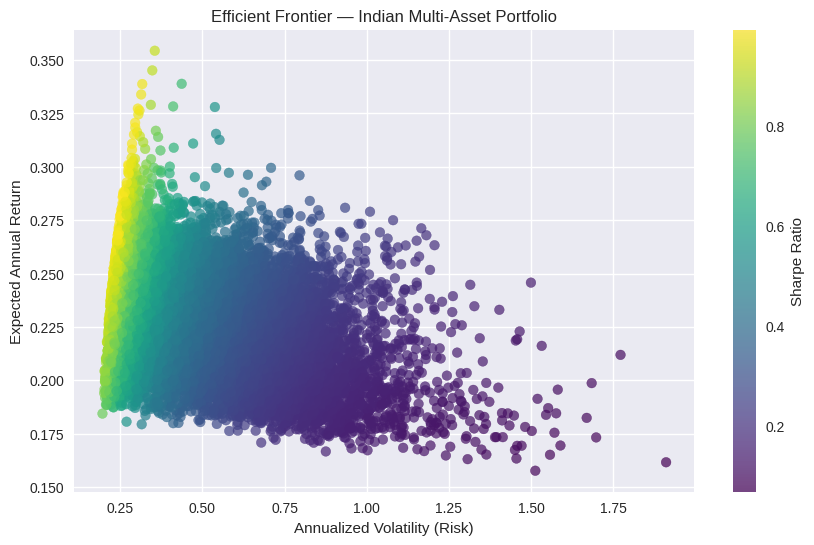

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier — Indian Multi-Asset Portfolio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Expected Annual Return')
plt.show()


Isolating Key Portfolios:
* Max Sharpe (the one with best risk-adjusted return)
* Minimum Volatility (the safest one overall)


In [9]:
max_sharpe_idx = results_df['Sharpe'].idxmax()
min_vol_idx = results_df['Volatility'].idxmin()

max_sharpe_port = results_df.loc[max_sharpe_idx]
min_vol_port = results_df.loc[min_vol_idx]

print("Max Sharpe Portfolio Weights:")
print(pd.Series(weights_record[max_sharpe_idx], index=tickers).map('{:.2%}'.format))

print("\nMin Volatility Portfolio Weights:")
print(pd.Series(weights_record[min_vol_idx], index=tickers).map('{:.2%}'.format))


Max Sharpe Portfolio Weights:
^NSEI             0.24%
GOLDBEES.NS      30.72%
INFY.NS           3.25%
TATAMOTORS.NS    33.78%
RELIANCE.NS      27.17%
TITAN.NS          4.83%
dtype: object

Min Volatility Portfolio Weights:
^NSEI             1.56%
GOLDBEES.NS      10.82%
INFY.NS           8.61%
TATAMOTORS.NS     1.26%
RELIANCE.NS      14.28%
TITAN.NS         63.48%
dtype: object


Risk Measurement


In [10]:
max_sharpe_weights = np.array(weights_record[max_sharpe_idx])
portfolio_returns = (log_returns @ max_sharpe_weights)

VaR_99 = np.percentile(portfolio_returns, 1)
print(f"99% Historical VaR (daily): {VaR_99:.2%}")


99% Historical VaR (daily): -4.56%
